# EE551 Embedded Image Processing
## Assignment 1 - Image Signal Processor (ISP)

### Background
An ISP is a processing block that converts raw sensor images into a colour array. There is a surprising amount of image processing that occurs between image capture and output colour images. In this assignment, you will implement a basic ISP.

You will be provided with samples of binary files containing raw sensor images (details of how to read these image files will be provided). The task is then to convert this raw data into a colour image.

The following processing will be done:
- Read in the image
- Demosaic (convert raw to RGB)
- Apply Colour Correction Matrix (matrix will be provided)
- Apply Denoise (e.g. bilateral filter)
- Apply Edge Enhancement (e.g. unsharp mask)
- Apply Contrast Enhancement (e.g. histogram equalisation)
- Save result to an output file

## Submission Details
Assignment deadline: Midnight, Sunday 27th October  \
Jupyter Notebook containing submission to be submitted via Canvas \
Total grade: 10% of final module mark \
Submit the assignment as a notebook (i.e. .iynb file) \
Use the following format for your filename: firstname_lastname_assignment1.ipynb


# Submission details:
#### Name: Patrick Noonan
#### ID:20355426
#### Class code:MECE

In [57]:
# Useful libraries
%matplotlib inline
import os
import os.path as op

import numpy as np
import cv2
from skimage import exposure
from scipy import ndimage
import matplotlib.pyplot as plt
from scipy import ndimage, misc, signal
from skimage.color import rgb2gray
from skimage import filters, feature, exposure, io, img_as_float


## Read in the raw image file

For this assignment, a raw image file will be provided. This is an image of a photographic test target. The pixel data
is stored as unsigned integers, 8 bits per pixel. The code for reading the image will be provided.

The general process is to read in the binary information, then reshape the array into the image dimensions (in this case, 4096*2160 pixels)


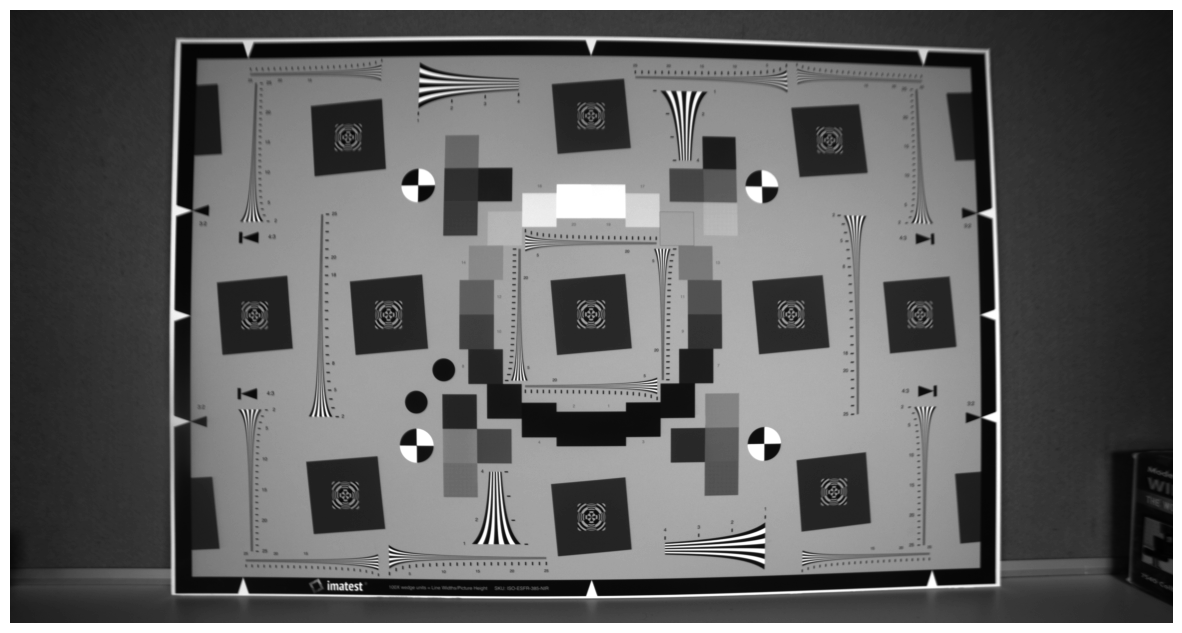

In [8]:
# Read in the file

# Raw file details:
# width - 4096
# height - 2160
# bit depth - 8
# Bayer pattern - rggb

bayer_width = 4096
bayer_height = 2160

raw_path = 'chart.raw'

bayer = np.fromfile(raw_path, dtype='uint8', sep='')

bayer = bayer.reshape((bayer_height, bayer_width))

plt.figure(figsize=(15,15))
plt.imshow(bayer,cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()


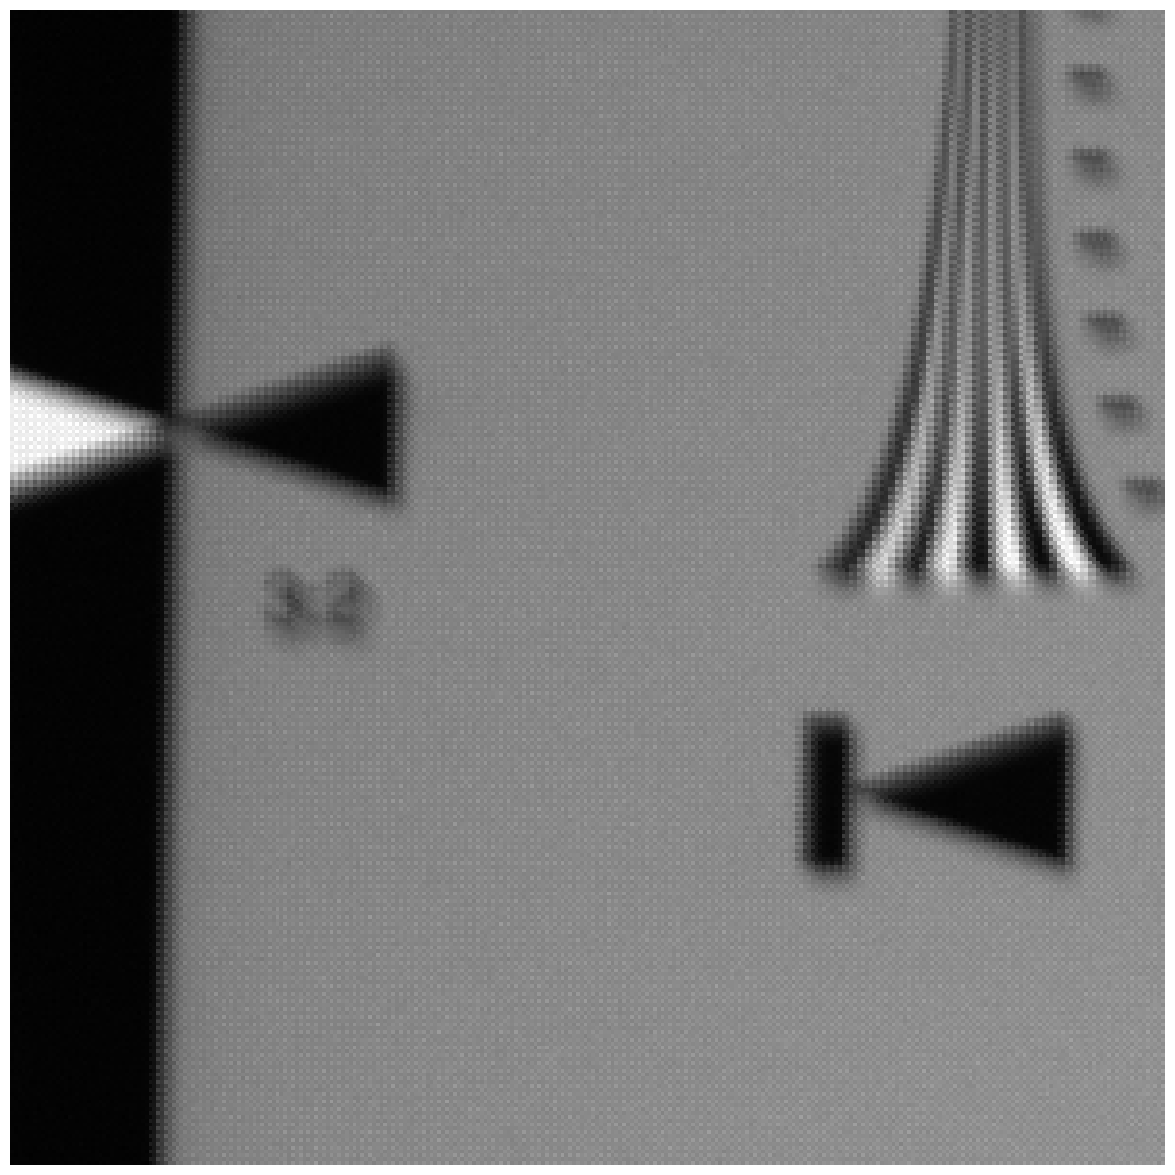

In [9]:
# crop and show a small area, to show the Bayer raw pattern

bayer_crop = bayer[600:900, 600:900] 

# plot the resulting raw file inline
plt.figure(figsize=(15,15))
plt.imshow(bayer_crop,cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

## Demosaic the image
The demosaic process converts raw pixel data into RGB image data. Each raw sensor pixel contains only one colour. Part of the demosaic process is to use interpolation to generate the missing colours for each pixel (i.e. a red pixel will get green and blue pixel information from the neighbouring pixels)

Hint: use the opencv "cvtColor" function. This function can be used to convert between many colour spaces. For this assignment, you'll want the "COLOR_BAYER_RG2BGR" option. 

more general details are available here: https://docs.opencv.org/3.4/de/d25/imgproc_color_conversions.html

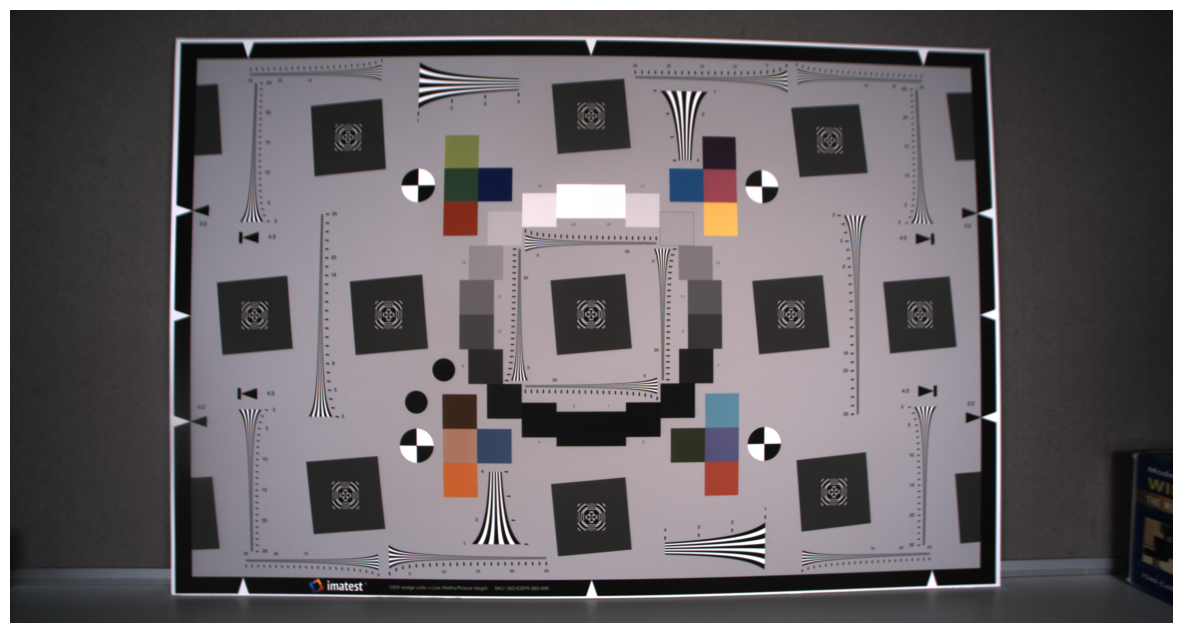

In [10]:
# Demosaic the image (i.e. covert from raw image to RGB)
convertedBayer = cv2.cvtColor(bayer, cv2.COLOR_BAYER_RG2BGR)
# plot the resulting raw file inline
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(convertedBayer)
plt.show()

## Comments on demosaicng
As you can see from the demosaicing process the colours in the image really 'pop' out of the frame. This is because demosaicing is interpolating the colour information from the image sensors as each sensor can only measure one of the three primary colours(red, green and blue) due to the bayer filter. So the colour of each pixel is interpolated from the neighboring image sensors data. 
For the black and white parts of the image don't cvhange alot with demosaicing. Grayscale parts of the image aren't effected by the interpolation of red, green and blue for their pixels hence why the black and white areas in the image still remain a little darker and only have luminance luminance adjustments. 

## Apply colour correction

A colour correction matrix is applied to improve colour reproduction accuracy. If you notice, red appears too orange before
correction is applied.

The colour correction matrix (CCM) is calculated during the camera development phase, and varies from camera to camera.

For simplicity, the CCM for this particular camera is provided below:
    
    [[ 1382, -113, -246], [ -484, 1808, -300], [ 102, -860, 1802]]
    
 
 This 3*3 matrix is multiplied by the RGB values for every pixel
 
 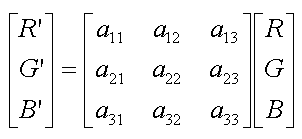
 
 
 
 Note that for embedded applications, floating point numbers are avoided wherever possible. In this example, the base is 1024 (i.e. to convert to floating point, divide the CCM by 1024)
 
 To apply the CCM in this example, the following steps are required:
 - cast the image to np.int32
 - multiply the RGB pixel data by the 3*3 CCM
 - divide by 1024 (note: this can be done by explicit division or right_shift by 10).
 - re-cast the image back to np.uint8
    

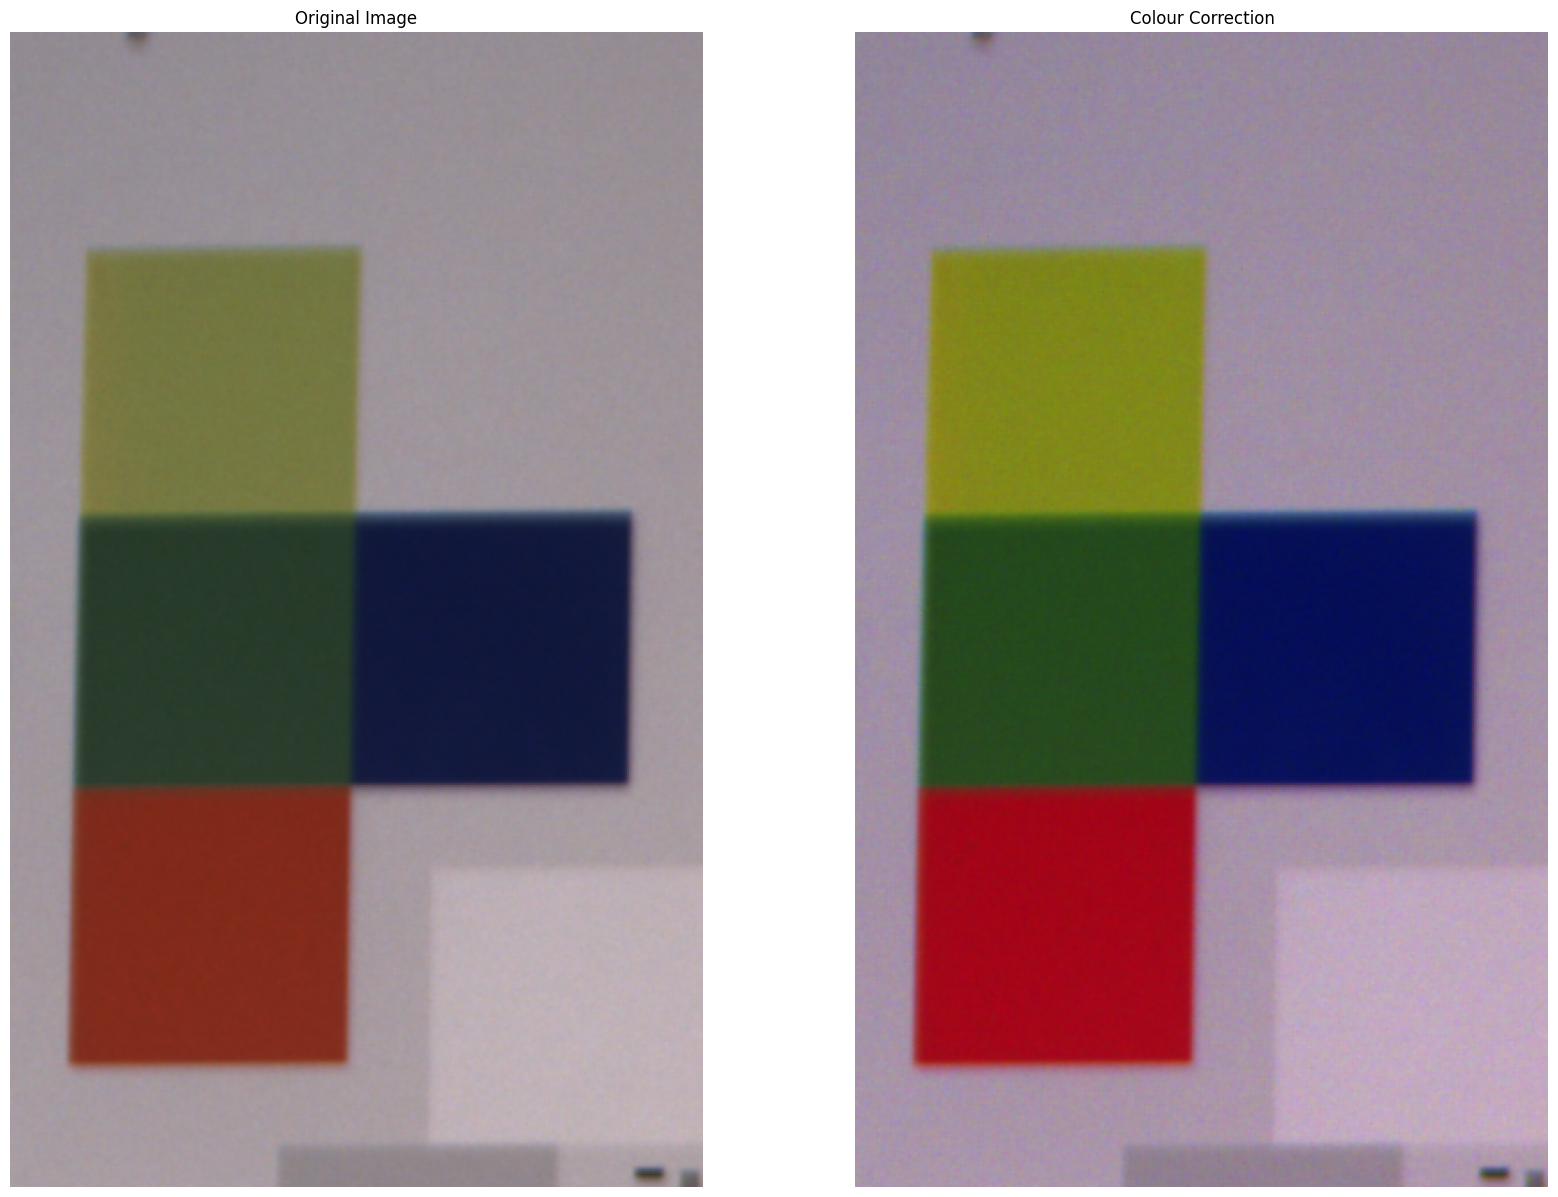

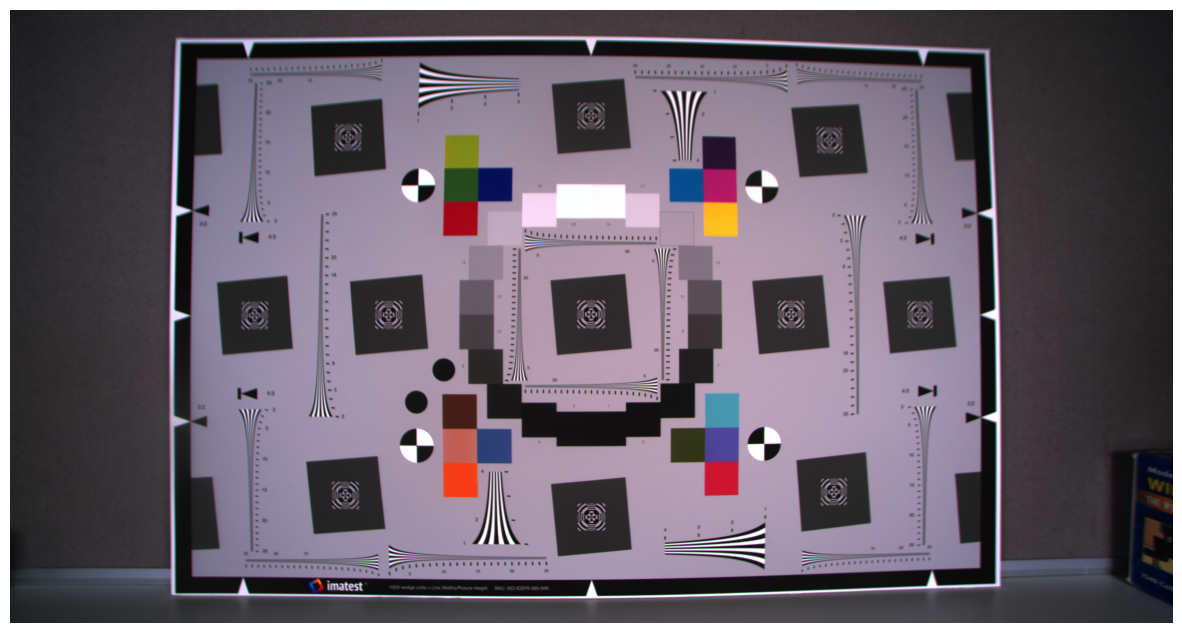

In [17]:
# apply colour correction matrix
# note: to avoid clipping, we have to temporarily cast our image data to int32, and then return to 8 bit

# hint - cast the ccm array and image as np.int32
# multiply the image by the ccm matrix, and then use np.right_shift to scale the image down to the 8 bit range again
# use the np.clip function to ensure the data range is within 0 and 255

ccm = np.array([[ 1382, -113, -246], [ -484, 1808, -300], [ 102, -860, 1802]],dtype=np.int32).T
colour_int32 = convertedBayer.astype(np.int32)
ccm_int32 = ccm.astype(np.int32)
result_image = np.dot(colour_int32, ccm )
result_image = np.right_shift(result_image, 10)
result_image = np.clip(result_image, 0, 255)
result_image_uint8 = result_image.astype(np.uint8)

colour_int32_crop = colour_int32[350:850, 1500:1800]
result_image_crop = result_image[350:850, 1500:1800] 

fig0, ax0 = plt.subplots(1, 2, figsize=(20, 15))

ax0[0].imshow(colour_int32_crop)
ax0[0].set_title("Original Image")
ax0[0].axis("off")

# Bilateral Filter
ax0[1].imshow(result_image_crop)
ax0[1].set_title("Colour Correction")
ax0[1].axis("off")

# plot the resulting raw file inline
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(result_image_uint8)
plt.show()



## Comments on colour correction
The biggest effect that the color correction has is changing the colour of the coloured boxes whiich can be seen by the orange box turning more to a blood red colour in the cropped images above and the green box turning much lighter aswell.
This makes the colours look more natural and pleasing as sometime digital images can have differences compared to the human eye.

## Apply gamma correction

Gamma correction is applied using the following formula:

$$
outputImage = ((inputImage / 255)^\gamma) * 255
$$

Typically, $$\gamma=1/2.2$$


hint - use numpy clip function to ensure the data range is within 0 and 255

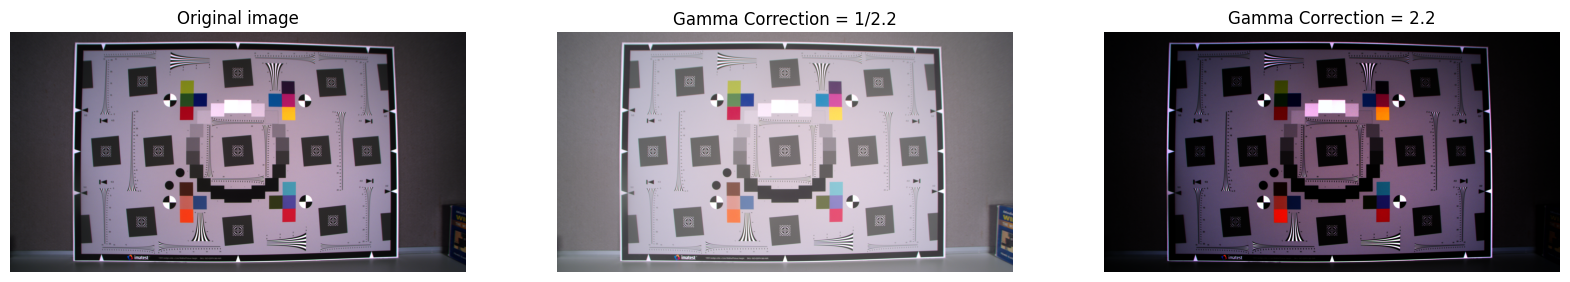

In [87]:
# apply gamma correction
lut = np.linspace(0,255,256).astype(np.uint8)
gamma0 = 1.0/2.2
gamma1 = 2.2

lut_gamma0 = np.array([(((i/255) ** gamma0) * 255)
for i in np.arange(0,256)]).astype(np.uint(8))

lut_gamma1 = np.array([(((i/255) ** gamma1) * 255)
for i in np.arange(0,256)]).astype(np.uint(8))

gammaCorrect0 = lut_gamma0[result_image_uint8]
gammaCorrect0 = np.clip(gammaCorrect0, 0, 255)

gammaCorrect1 = lut_gamma1[result_image_uint8]
gammaCorrect1 = np.clip(gammaCorrect1, 0, 255)

fig, ax = plt.subplots(1, 3, figsize=(20, 15))

# Original Image
ax[0].imshow(result_image_uint8)
ax[0].set_title("Original image")
ax[0].axis("off") 

ax[1].imshow(gammaCorrect0)
ax[1].set_title("Gamma Correction = 1/2.2")
ax[1].axis("off")

ax[2].imshow(gammaCorrect1)
ax[2].set_title("Gamma Correction = 2.2")
ax[2].axis("off")
plt.show()


## Comments on gamma correction
- As you can see form the images above the middle image is the actual gamma corrected value and you can see the colours are alot more balanced and it isn't over or underexposed you can see all of the different targets on the chart quite well and it is wel balanced.
- The first image seems a little darker then usual and the colour scheme doesn't look as balanced as the middle image this is our baseliine image before any gamma correction takes place.
- This image is clearly over corrected creating an image that is too dark you can see some features are lost in the colour mapo sue to this and the contrast between white and black colours are clearly not in the correct ratio. 

## Apply denoise to image

For this block, it is up to the student to decide which denoise block to use (there are several options available). 

One good option would be openCV's bilateral filter

Hint - experiment with parameters, examine the effect of different parameters on the image. There isn't necessarily a right or wrong configuration, but changing the parameters will have an impact on the final image

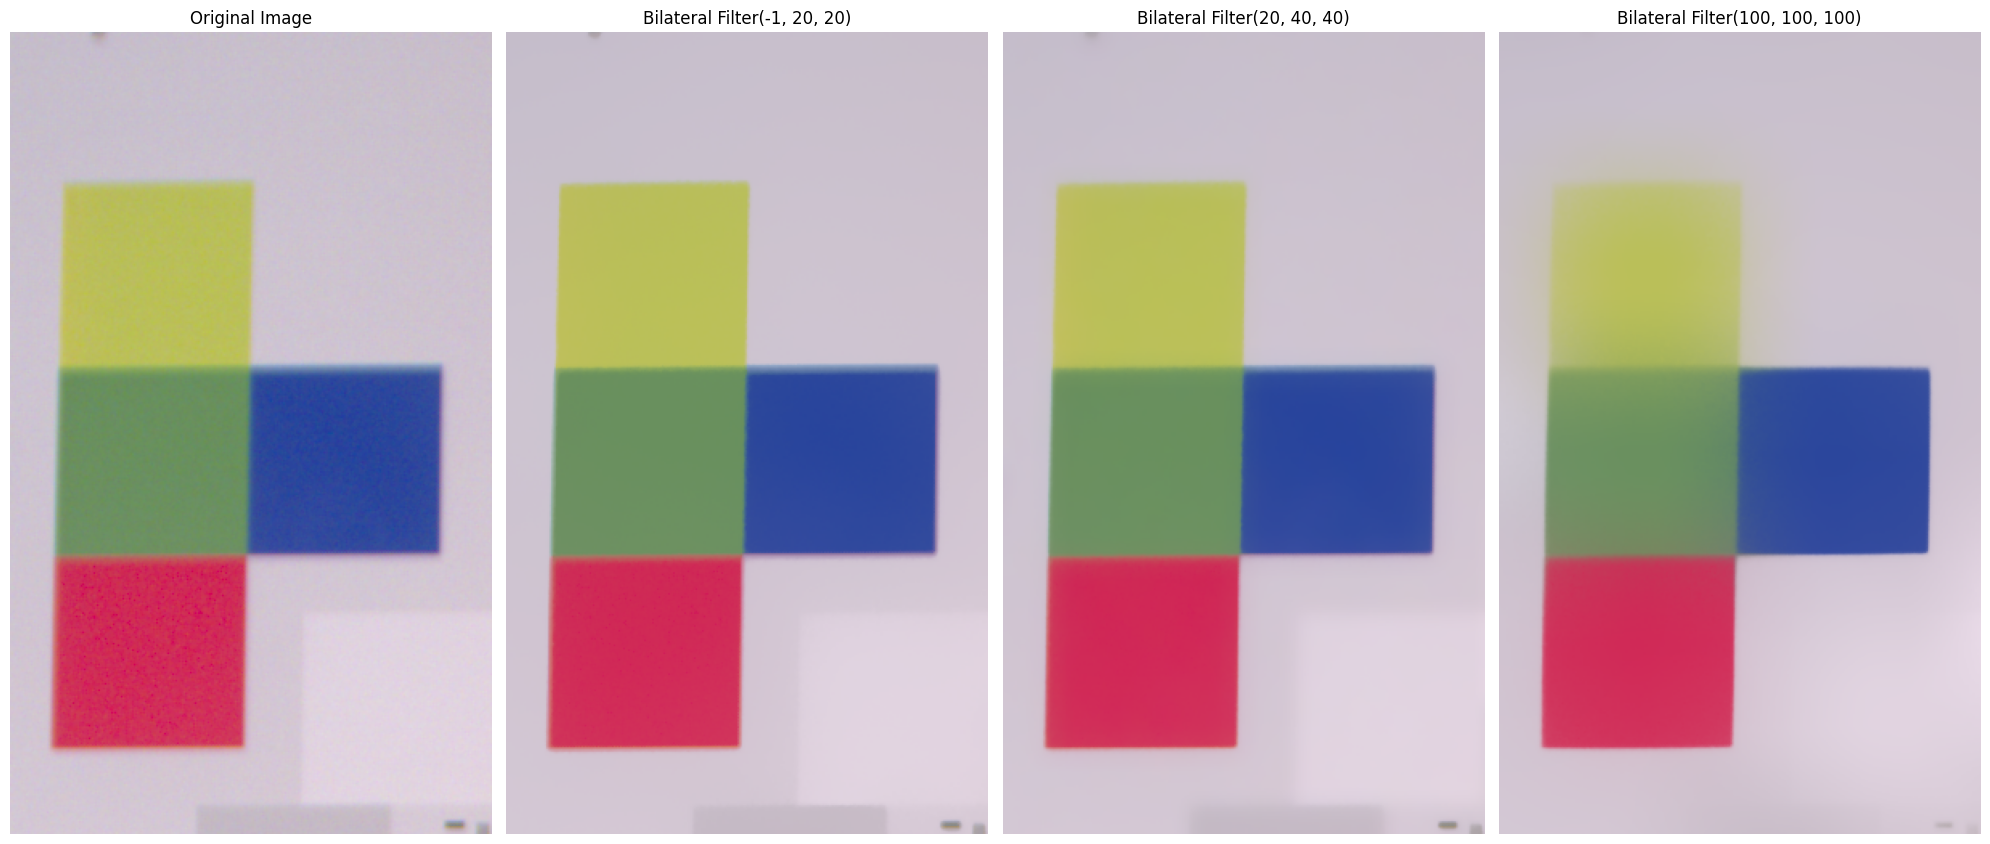

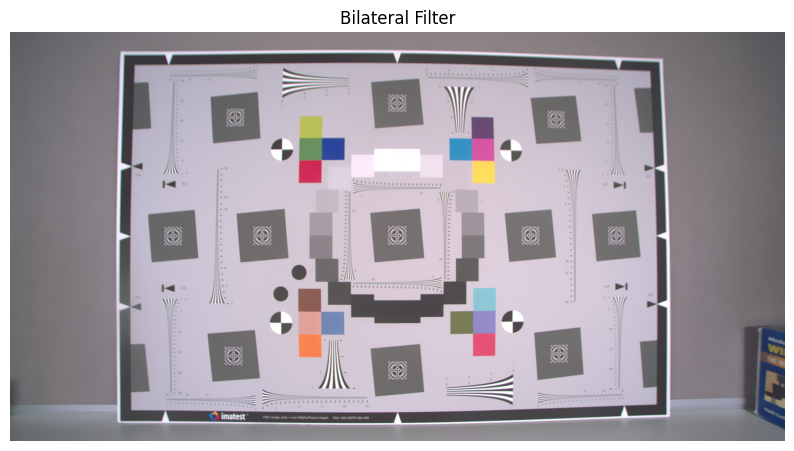

In [86]:
# apply image denoise filtering (bilateral filter)
# hint - use opencv cv2.bilateral filter

# experiment with filter coefficients to see the impact on the image. It might help to crop on an area to get the full effect
im_out_uint8 = gammaCorrect0.astype(np.uint8)
bilateral0 = cv2.bilateralFilter (im_out_uint8, -1, 20, 20)
bilateral1 = cv2.bilateralFilter (im_out_uint8, 20, 40, 40)
bilateral2 = cv2.bilateralFilter (im_out_uint8, 100, 100, 100)

im_out_uint8_crop = im_out_uint8[350:850, 1500:1800]
bilateral_crop0 = bilateral0[350:850, 1500:1800] 
bilateral_crop1 = bilateral1[350:850, 1500:1800] 
bilateral_crop2 = bilateral2[350:850, 1500:1800] 

fig0, ax0 = plt.subplots(1, 4, figsize=(20, 15))

ax0[0].imshow(im_out_uint8_crop)
ax0[0].set_title("Original Image")
ax0[0].axis("off")

# Bilateral Filter
ax0[1].imshow(bilateral_crop0)
ax0[1].set_title("Bilateral Filter(-1, 20, 20)")
ax0[1].axis("off")

# Bilateral Filter
ax0[2].imshow(bilateral_crop1)
ax0[2].set_title("Bilateral Filter(20, 40, 40)")
ax0[2].axis("off")

# Bilateral Filter
ax0[3].imshow(bilateral_crop2)
ax0[3].set_title("Bilateral Filter(100, 100, 100)")
ax0[3].axis("off")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(bilateral0)
plt.title("Bilateral Filter")
plt.axis("off")

plt.show()

## Comments on Denoising
- As you can see from the zoomed up image on the boxes of colour we can see the effects of the bilateral filter here and the adjustments to its parameters also.
- The first Bilateral picture maintains edges well and the denoising is very efffective. The -1 for d sets the pixel neighborhood to the most efficient number so this is why the edges maintain very nicely. Also small sigma color and sigma space values means that only pixels with similar colours are smoothed and the filter only takes into account nearby pixels with a big infl;uence on the one being processed.
- The secoond image has an increase in diameter of pixel neighbourhood and the sigma space and sigma colour is also doubled. This causes pixels further away from the processed pixel to have an effect on it and also different colour pixels having more of an effect on the processed pixel. This isn't overly effected in the third image but you can see the grey and white box in the bottom right hand corner fading. 
- In the third bilateral image the pixel neighbourhood, sigma space and sigma colour are all increased to 100 which makes the neighbour quite sizeable and an even more variation of colour being allowed to be procesed and have an effect on the processed pixel.This will have a bigger effect on blurring the edges in the image which can be seen with the green square fading alot and the grey and white square in the bottom right corner completely disappearing from the image. 

## Apply edge enhancement

Apply edge enhancement to the image. Again, it is up to the student to select the edge enhancement approach used (we covered a few options in class)

Again, vary the parameters and see the impact on the image

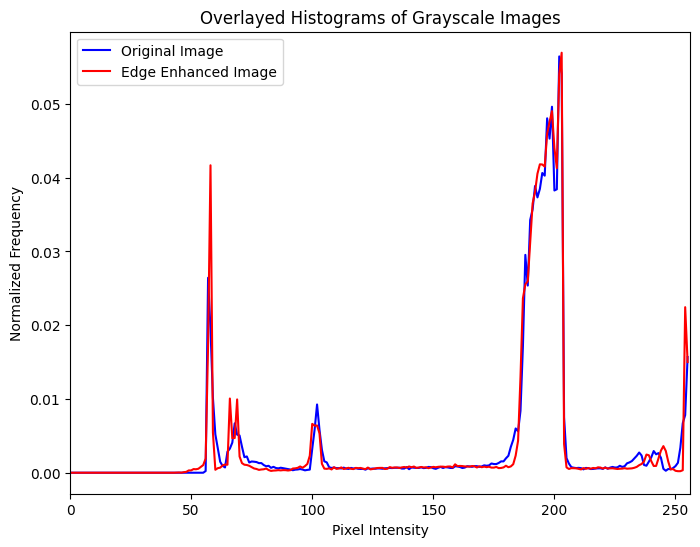

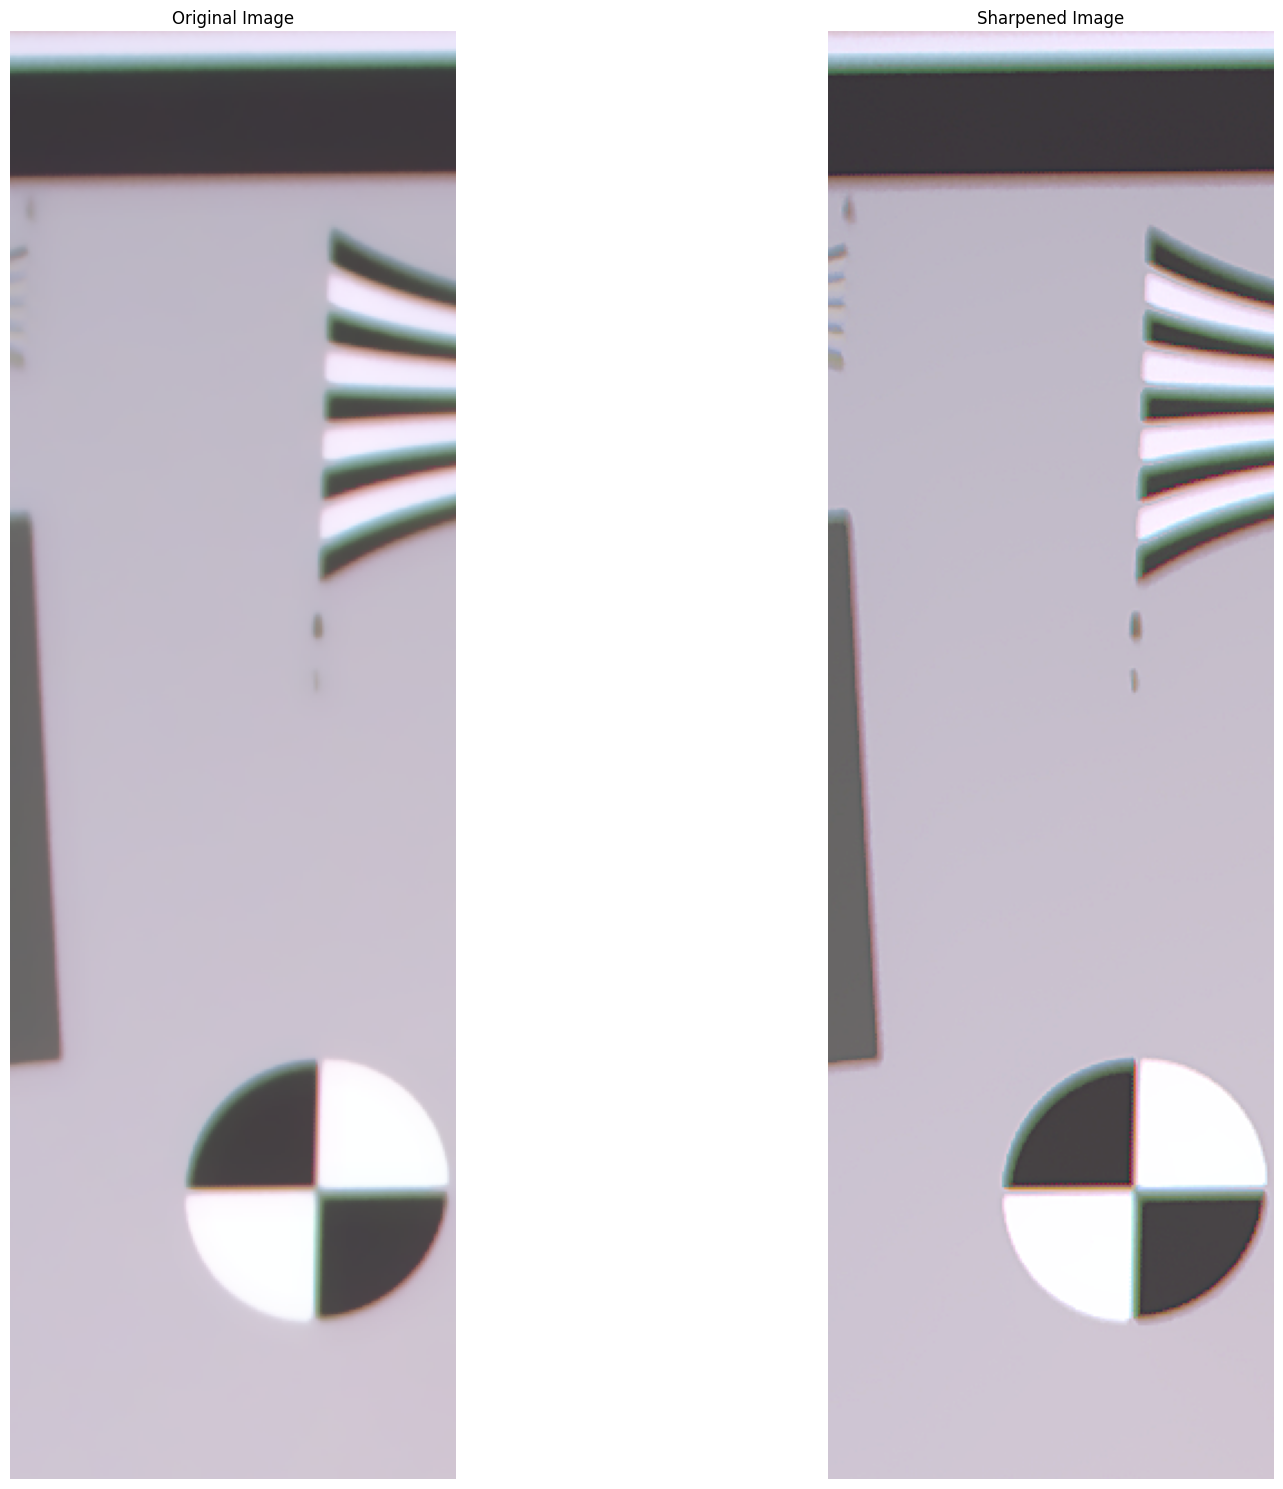

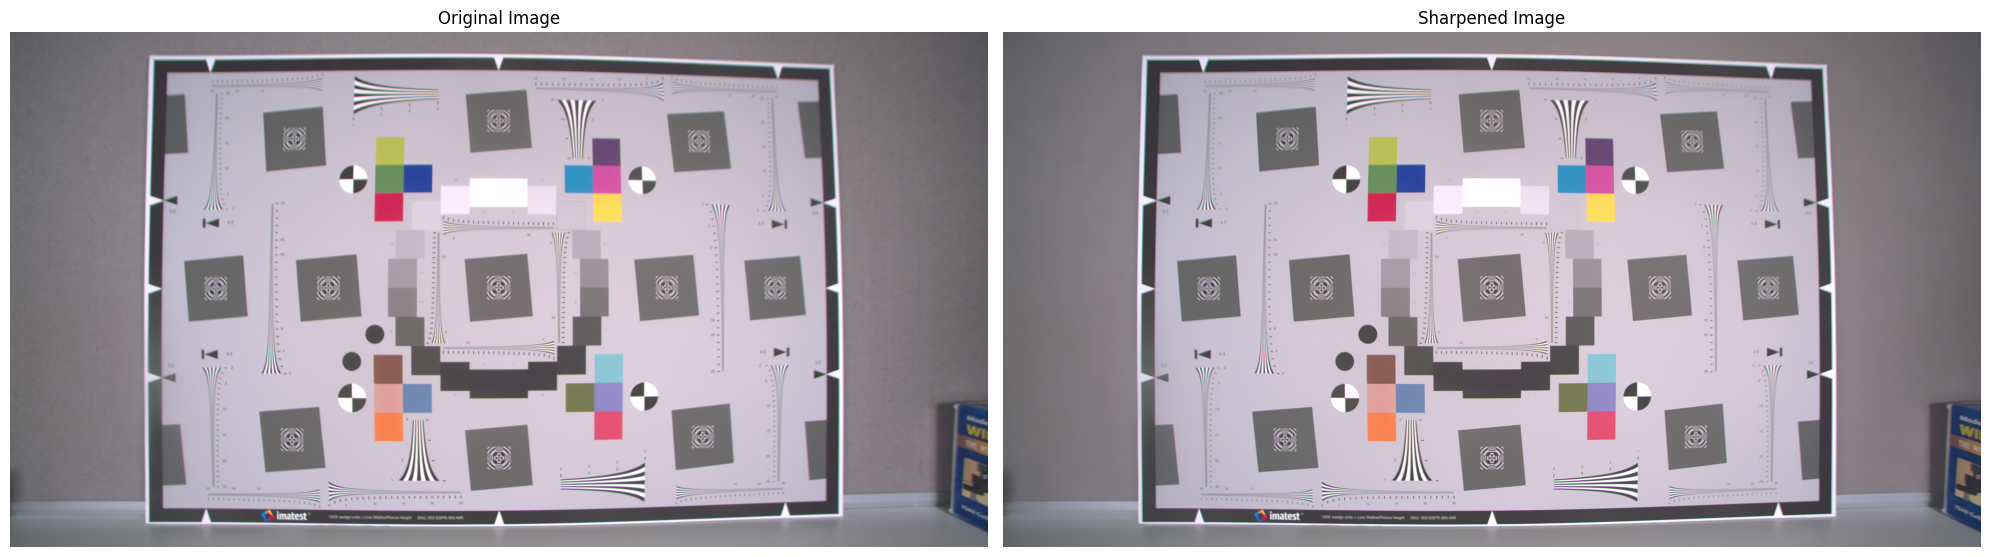

In [91]:
# apply edge enhancement
# hint: implement Laplacian or unsharp mask filtering from previous course material. 
##define LaPlace kernel - first implementation
#edge_laplace_kernel_1 = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])
##define LaPlace kernel - second implementation
#edge_laplace_kernel_2 = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
#grayscale_image = cv2.cvtColor(im_out_uint8, cv2.COLOR_BGR2GRAY).astype(float)
#grayscale_image_uint8 = cv2.cvtColor(im_out_uint8, cv2.COLOR_BGR2GRAY).astype(np.uint8)
#
##Laplacian Edge Detection
#im_edges_1 = np.clip(signal.convolve2d(grayscale_image, edge_laplace_kernel_1), 0, 1)
#
#im_edges_2 = np.clip(signal.convolve2d(grayscale_image, edge_laplace_kernel_2), 0, 1)
#
#fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(18,6))
#axes[0].imshow(im_out_uint8, cmap=plt.cm.gray)
#axes[0].set_title('Original Image', size=15)
#axes[1].imshow(im_edges_1, cmap=plt.cm.gray)
#axes[1].set_title('Laplacian filter - type 1', size=15)
#axes[2].imshow(im_edges_2, cmap=plt.cm.gray)
#axes[2].set_title('Laplacian filter - type 2', size=15)

##Unsharp Masking
blurred = cv2.GaussianBlur(bilateral0, (5, 5), sigmaX=1.0)
alpha = 1.5
edgeEnhanced = cv2.addWeighted(bilateral0, 1.0 + alpha, blurred, -alpha, 0)

#Creating Histogram to detect the edges
bilateral1_crop = bilateral1[100:750, 1300:1500]
edgeEnhanced_crop = edgeEnhanced[100:750, 1300:1500]
 
gray_bilateral1_crop = cv2.cvtColor(bilateral1_crop, cv2.COLOR_BGR2GRAY)
gray_sharpened_crop = cv2.cvtColor(edgeEnhanced_crop, cv2.COLOR_BGR2GRAY)

hist_bilateral1_crop = cv2.calcHist([gray_bilateral1_crop], [0], None, [256], [0, 256])
hist_sharpened_crop = cv2.calcHist([gray_sharpened_crop], [0], None, [256], [0, 256])

hist_bilateral1_crop = hist_bilateral1_crop / hist_bilateral1_crop.sum()
hist_sharpened_crop = hist_sharpened_crop / hist_sharpened_crop.sum()

plt.figure(figsize=(8, 6))
plt.plot(hist_bilateral1_crop, color='blue', label='Original Image')
plt.plot(hist_sharpened_crop, color='red', label='Edge Enhanced Image')


plt.title('Overlayed Histograms of Grayscale Images')
plt.xlim([0, 256])
plt.xlabel('Pixel Intensity')
plt.ylabel('Normalized Frequency')
plt.legend()
plt.show()

%matplotlib inline
# plot the resulting raw file inline
fig0, ax0 = plt.subplots(1, 2, figsize=(12, 6))

ax0[0].imshow(bilateral1_crop)
ax0[0].set_title("Original Image")
ax0[0].axis("off") 

ax0[1].imshow(edgeEnhanced_crop)
ax0[1].set_title("Sharpened Image")
ax0[1].axis("off")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(im_out_uint8)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(edgeEnhanced)
ax[1].set_title("Sharpened Image")
ax[1].axis("off")

plt.tight_layout()
plt.show()


## Comments on Edge Enhancement
- The edge enhancement algorithm used is the unsharp masking algorithm. 
- It is hard to see any difference in the full images that are printed above but in the zoomed in images you can see the edges are more defined especially in high contrast areas like in regios of black and white edges.
- Also the majority of the red peaks in the histogram are higher then the blue peaks meaning there are sharper edges. The one blue peak that is higher then the red could be down to an aspect ratio issue or the intesities could be located in an area that isn't affected by edge enhancement.

## Apply contrast enhancement

Finally, apply contrast enhancement to the image. It is up to the student to select the contrast enhancement used. One option would be adaptive histogram equalization, covered in Section 2 (check out the skimage exposure library). And again, vary the parameters to examine the effect on the final image

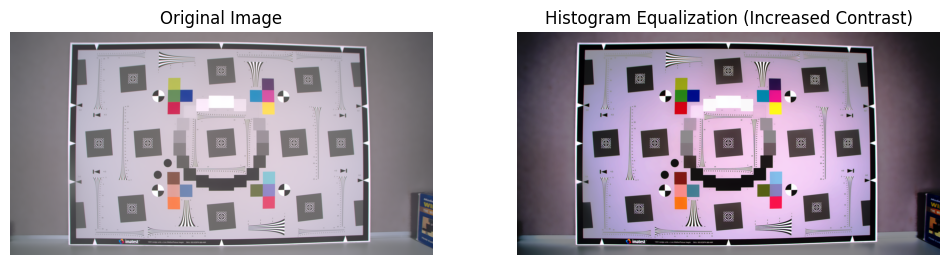

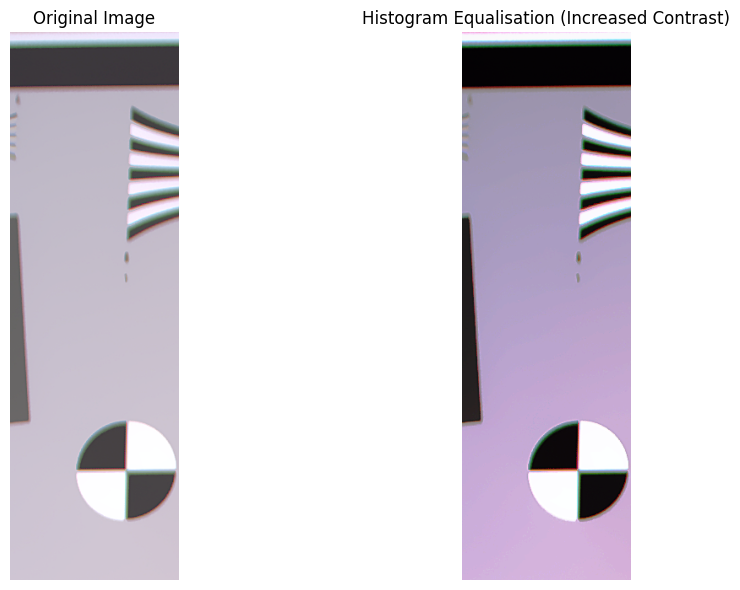

In [81]:
# increase image contrast. Hint - check out skimage exposure

# Rescale intensity to increase contrast

# Rescale intensity to stretch the pixel values across the full range (0 to 1)
# Apply histogram equalization
equalized_image = exposure.equalize_hist(edgeEnhanced)

# Plot the results
sharpened_crop = edgeEnhanced[100:750, 1300:1500]
equalised_crop = equalized_image[100:750, 1300:1500]

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(edgeEnhanced, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(equalized_image, cmap='gray')
ax[1].set_title('Histogram Equalization (Increased Contrast)')
ax[1].axis('off')


fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(sharpened_crop, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(equalised_crop, cmap='gray')
ax[1].set_title('Histogram Equalisation (Increased Contrast)')
ax[1].axis('off')

plt.tight_layout()
plt.show()

## Commments on contrast enhancement
- To increase colour contrast histogram equalisation is used. This method redistributes the intensities based on the image's histogram, so the output image has a more uniform distribution of pixel values.
- This utilizes a full dynamic range(0-255) which enhances the visibility of the image and brings out details that weren't previously visible.
- It effectively spreads out the highly populated intensity values which are used to degrade image contrast. 
- Edges and details in the image become more prominent, as the enhanced contrast makes previously indistinct areas stand out more clearly. In some cases this may lead to exagerated contrast between dark and light areas. The contrast above is quite well balanced though and enhances the details in the image.